### Titanic

* https://www.kaggle.com/c/titanic

In [398]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
from pathlib import Path
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *

import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Project overview

In [401]:
"""
https://www.kaggle.com/c/titanic/data

Hypothesis (important features)
- Gender
- PClass = Ticket class (proxy for socioeconomic status)
- Age

Other
- Fare
- Embarked
- Name (Dr, Sir)

891 passengers
predict whether they survived or not


Next Up
-------
0) Outlier detection and handling
1) Identifying missclassified examples
2) Other error metrics
3) Confusion matrix
4) Other statistical tests
5) K-Fold CV
6) Grid Search
7) Feature creation
8) Correctly interpreting logistic regresssion coefficients
9) Feature correlation analysis

Notes
-----
0) Combine train/test distributions early for exploratory analysis (compare
1) Perform feature correlation analysis early in project

Review the Kaggle Kernels?
""";

### Load Data

In [402]:
DATA_PATH = '/home/bfortuner/.kaggle/competitions/titanic'
TRAIN_PATH = Path(DATA_PATH, 'train.csv')
TEST_PATH = Path(DATA_PATH, 'test.csv')
train = pd.read_csv(TRAIN_PATH)

### Summary Stats

In [403]:
# Columns, dtype, size
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [404]:
# Basic stats - mean, min, max, std, quartiles
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [405]:
# Describe categorical data
train.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Carlsson, Mr. August Sigfrid",male,347082,G6,S
freq,1,577,7,4,644


In [406]:
# Unique counts
train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [407]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [408]:
# Count null values
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Hypothesis testing

In [409]:
"""
Women (Sex=female) were more likely to have survived.
Children (Age<?) were more likely to have survived.
The upper-class passengers (Pclass=1) were more likely to have survived.
""";

In [410]:
# Did more rich people survive?
train[['Pclass', 'Survived']].groupby(
    ['Pclass'], as_index=False).mean().sort_values(
    by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [411]:
# What percentage of women survived?
train[['Sex', 'Survived']].groupby(
    ['Sex'], as_index=False).mean().sort_values(
    by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [412]:
# What percentage of women survived?
train[['Sex', 'Survived']].groupby(
    ['Sex'], as_index=False).mean().sort_values(
    by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


### Histograms 

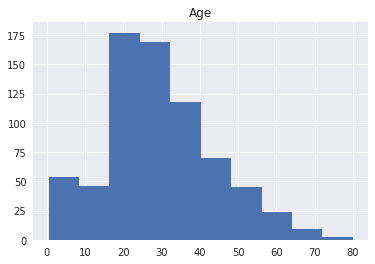

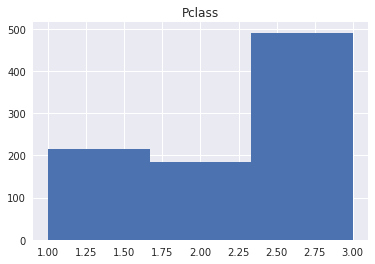

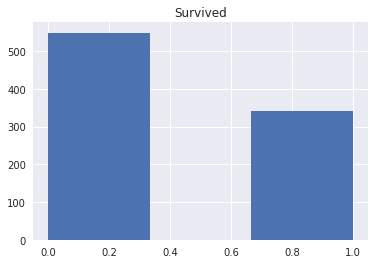

In [413]:
# Numerical
train.hist(column='Age');
train.hist(column='Pclass', bins=3);
train.hist(column='Survived', bins=3);

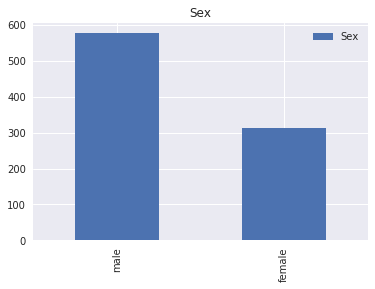

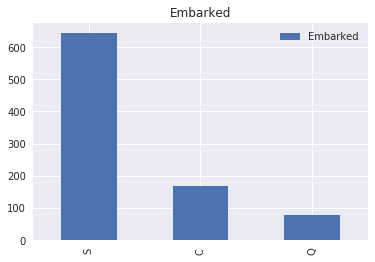

In [414]:
# Strings
train[['Sex']].apply(pd.value_counts).plot(kind='bar', subplots=True);
train[['Embarked']].apply(pd.value_counts).plot(kind='bar', subplots=True);

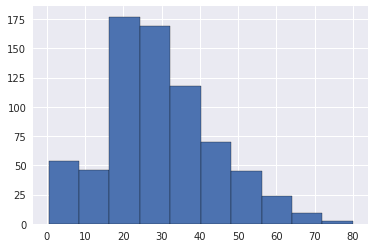

[100 346 188  69  11] [ 0.42  16.336 32.252 48.168 64.084 80.   ]


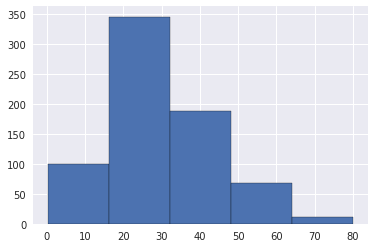

In [415]:
# Histograms with Numpy (more control over bin size)
arr = train[['Age']].dropna().as_matrix()
counts, edges = np.histogram(arr)

fig, ax = plt.subplots()
ax.bar(edges[:-1], counts, width=np.diff(edges), ec="k", align="edge")
plt.show()


# Set number of bins
counts, edges = np.histogram(arr,bins=5)
print(counts, edges)

fig, ax = plt.subplots()
ax.bar(edges[:-1], counts, width=np.diff(edges), ec="k", align="edge")
plt.show()

### Correlation / Covariance

In [416]:
"""
Try to get a sense of patterns/relationship between features and target
1) Covariance matrix
2) Pearson correlation coefficient
""";

In [417]:
include_cols = ['Age', 'Fare', 'Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch', 'Name']
df = train[include_cols].copy()

In [418]:
# Cleanup Nulls
df.fillna({
    "Age": -1,
    "Embarked": 'X',    
}, inplace=True)
print(df.isnull().sum())

Age         0
Fare        0
Sex         0
Pclass      0
Embarked    0
SibSp       0
Parch       0
Name        0
dtype: int64


In [419]:
# Convert Categorical
df['Sex'] = df['Sex'].astype('category')
df['Sex'] = df['Sex'].cat.codes

# One-hot encode
df = pd.get_dummies(df, columns=['Embarked'], prefix=['Emb'])

# Create name feature
df['fancy_name'] = np.where(
    (df.Name.str.contains('Dr\.')) | (df.Name.str.contains('Sir\.'))
    , 1, 0)

# Create is_infant 
df[np.logical_and(df.Age < 1, df.Age > 0)]
df.head()

,Age,Fare,Sex,Pclass,SibSp,Parch,Name,Emb_C,Emb_Q,Emb_S,Emb_X,fancy_name
0,22.0,7.2500,1,3,1,0,"Braund, Mr. Owen Harris",0,0,1,0,0
1,38.0,71.2833,0,1,1,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,0,0,0
2,26.0,7.9250,0,3,0,0,"Heikkinen, Miss. Laina",0,0,1,0,0
3,35.0,53.1000,0,1,1,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0,1,0,0
4,35.0,8.0500,1,3,0,0,"Allen, Mr. William Henry",0,0,1,0,0


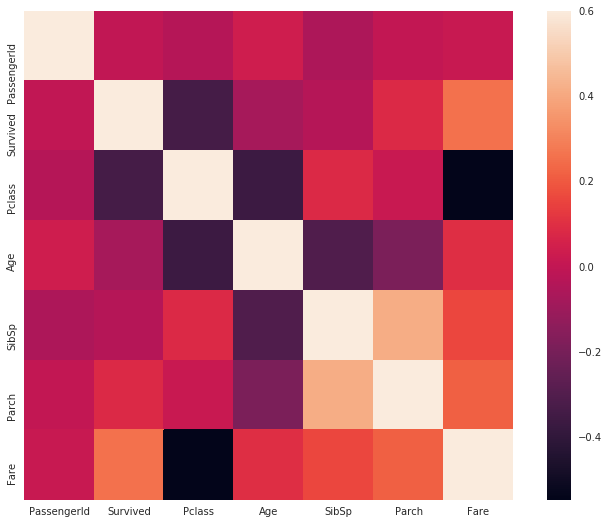

In [420]:
# Covariance matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.6, square=True);

In [421]:
# Get the n variables most correlated with Target (Survivied)
cols = corrmat.nlargest(n=3, columns='Survived')['Survived'].index
cols

Index(['Survived', 'Fare', 'Parch'], dtype='object')

### Handle Null Values

In [422]:
"""
Options
------
1) Drop columns with too many null values
2) Drop rows with null values
3) Set Null values to constant placeholder (e.g. -9999999)
    * Binary Features
        -1 for negatives
        0 for missing values
        1 for positives
4) Backfill with Mean, Median, Mode of column
5) Backfill based on similar rows/class labels (clustering, class labels)
6) Time-series = forward / backward fill (fill with previous non-null value)
...

""";

In [423]:
# Drop rows with null values
df = train.copy()
print(df.isnull().sum())

# Drow rows with null values in 'Age' column
df = df.dropna(how='any', subset=['Age'])

# Drop rows with null values in any column
df = df.dropna(how='any')
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [424]:
# Replace with constant
"""
* Binary Features
    -1 for negatives
    0 for missing values
    1 for positives
"""
df = train.copy()
print(df['Cabin'].isnull().sum())
df = df[['Cabin']].fillna(value=9999) 
df['Cabin'].isnull().sum()

687


0

Mode 0    S
dtype: object
Median 28.0
Mean 29.69911764705882
male      577
female    314
Name: Sex, dtype: int64
S    644
C    168
Q     77
Name: Embarked, dtype: int64
3    491
1    216
2    184
Name: Pclass, dtype: int64
After 0


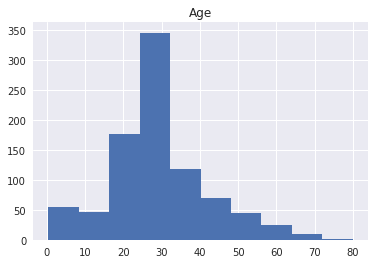

In [425]:
# Fill with most common value

# Mode, median, mean
print("Mode", train['Embarked'].mode())
print("Median", train['Age'].median())
print("Mean", train['Age'].mean())

# Other possibilities
print(train["Sex"].value_counts())
print(train["Embarked"].value_counts())
print(train["Pclass"].value_counts())

# Replace with Median
df = train.copy()
df = df[['Age']].fillna(value=df['Age'].median())
print("After", df['Age'].isnull().sum())
df[['Age']].hist();

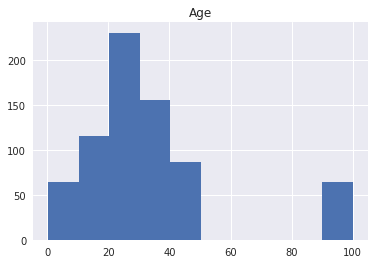

In [426]:
# Conditionally fill values
df = train.copy()
df['Age'] = np.where(df['Age'] > 50, 100, df['Age'])
df[['Age']].hist();

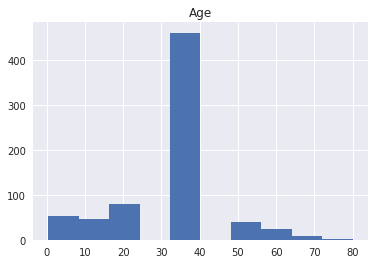

In [427]:
# Conditionally fill with multiple conditions
df = train.copy()
df['Age'] = np.where((df['Age'] > 20) & (df['Age'] < 50), 40, df['Age'])
df[['Age']].hist();

In [428]:
# Fill nulls in multiple columns simultaneously
df = train.copy()
df = df.fillna({
    "Age": 999,
    "Embarked": "C",
    "Cabin": "N"
})
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [429]:
# Bfill/Ffill
# Fill with last/next value in sequence
# Good for time series!

df = train.copy()
df = df[['Age']].fillna(method='bfill')
df = df[['Age']].fillna(method='ffill')
df[['Age']].isnull().sum()

Age    0
dtype: int64

In [430]:
# For our purposes, let's fill with constants
train = train.fillna({
    "Age": 999,
    "Embarked": "C",
    "Cabin": "N"
})
df.isnull().sum()

Age    0
dtype: int64

### Feature Selection

In [431]:
"""
* Simple features
* Features with high correlation with target
* Features with low correlation with other features

Make sure to include the target label at this stage (before train/test split)
"""

FEATURES = ['Pclass', 'Sex', 'Embarked', 'Survived']
TARGET = 'Survived'
features = train[FEATURES].copy()
features.head()

,Pclass,Sex,Embarked,Survived
0,3,male,S,0
1,1,female,C,1
2,3,female,S,1
3,1,female,S,1
4,3,male,S,0


### Categorical Encoding

* http://pbpython.com/categorical-encoding.html

In [434]:
"""
Converting text values into numbers

Binary = True/False (Male/Female)
    - Convert to 0/1
Nominal = class names (Dog, Cat, Mouse)
    - One-hot encoding
Ordinal = order matters (Low, Medium, High)
    - Label encoding
Interval (1-10, 11-20, ..)
    - ??
Continuous (1.2, 1.5, 1.6, ..)
    - Consider binning and converting to Interval
    - ?? - look at how to do this later
""";

In [435]:
# With numpy np.where
df = features.copy()
df['Sex'] = np.where(df['Sex'] == 'male', 0, 1)
df.head()

,Pclass,Sex,Embarked,Survived
0,3,0,S,0
1,1,1,C,1
2,3,1,S,1
3,1,1,S,1
4,3,0,S,0


In [436]:
# With find and replace
df = features.copy()
df.replace({
    "Sex": {
        "male": 0,
        "female": 1
    },
    "Embarked": {
        "S": 0,
        "C": 1,
        "Q": 2
    }
}, inplace=True)
df.head()

,Pclass,Sex,Embarked,Survived
0,3,0,0,0
1,1,1,1,1
2,3,1,0,1
3,1,1,0,1
4,3,0,0,0


In [437]:
# Pandas 'category' codes
"""
Good for ordinal (order matters)
Bad for nominal with many categories
"""
df = features.copy()
df['Embarked'] = df['Embarked'].astype('category')
df['Embarked'] = df['Embarked'].cat.codes
df.head()

,Pclass,Sex,Embarked,Survived
0,3,male,2,0
1,1,female,0,1
2,3,female,2,1
3,1,female,2,1
4,3,male,2,0


In [438]:
# One hot encoding (typically best for all but binary features)
"""
Label encoding (1,2,3,4) has the advantage that it is straightforward but it has the disadvantage that the numeric values can be “misinterpreted” by the algorithms. 

For example, the value of 0 is obviously less than the value of 4 but does that really correspond to the data set in real life? Does a wagon have “4X” more weight in our calculation than the convertible? In this example, I don’t think so.
"""
df = features.copy()
df = pd.get_dummies(df, columns=['Embarked'], prefix=['Emb'])
df.head()

,Pclass,Sex,Survived,Emb_C,Emb_Q,Emb_S
0,3,male,0,0,0,1
1,1,female,1,1,0,0
2,3,female,1,0,0,1
3,1,female,1,0,0,1
4,3,male,0,0,0,1


In [439]:
# For our purposes, let's use category codes for male/female and one hot for embarked
features = train[FEATURES].copy()
features = pd.get_dummies(features, columns=['Embarked'], prefix=['Emb'])
features['Sex'] = features['Sex'].astype('category')
features['Sex'] = features['Sex'].cat.codes
features.head()

,Pclass,Sex,Survived,Emb_C,Emb_Q,Emb_S
0,3,1,0,0,0,1
1,1,0,1,1,0,0
2,3,0,1,0,0,1
3,1,0,1,0,0,1
4,3,1,0,0,0,1


### Feature Engineering

In [440]:
"""
Simple
------
1) Convert timestamps into Day, Week, Month, Year
2) Combine two features into a new feature
3) Convert continous features into bins
4) Normalization
    - Especially continuous variables with large ranges
5) Create Polynomial features

Advanced
--------
1) Dimensionality Reduction (PCA, SVD, T-SNE, K-Means)
2) ....
""";

In [ ]:
# Binning continuous features


In [498]:
# Normalization


In [ ]:
# Polynomial Features
    # When to use?
    # Pro/Con

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)

### Train/Test Split

In [441]:
"""
Approaches
    * Split on time
    * Randomly shuffle
    * Balance classes

Split size
    * Train/Val
    * K-Fold
    
Convert to Numpy
""";

In [442]:
# Shuffle (Pandas)
features = features.sample(frac=1)
features.head()

,Pclass,Sex,Survived,Emb_C,Emb_Q,Emb_S
125,3,1,1,1,0,0
130,3,1,0,1,0,0
552,3,1,0,0,1,0
561,3,1,0,0,0,1
328,3,0,1,0,0,1


In [443]:
# Train/Test Split
Y = features[TARGET].as_matrix()

X = features.copy()
X = X.drop(axis=1, labels=[TARGET])
x_columns = X.columns
X = X.as_matrix()

X[:10],Y[:10]

(array([[3, 1, 1, 0, 0],
        [3, 1, 1, 0, 0],
        [3, 1, 0, 1, 0],
        [3, 1, 0, 0, 1],
        [3, 0, 0, 0, 1],
        [3, 1, 0, 0, 1],
        [3, 1, 0, 0, 1],
        [3, 0, 1, 0, 0],
        [1, 1, 0, 0, 1],
        [3, 1, 0, 0, 1]]), array([1, 0, 0, 0, 1, 0, 0, 1, 1, 0]))

In [444]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42
)

### Simple Baseline

In [445]:
"""
Classification

* Logistic Regression
* Naive Bayes
* Decision Tree 
""";
seed = 42

### Logistic Regression

In [446]:
"""
* Classification algorithm
* Linear regression with Sigmoid() to get probabilities

Pros
* Fast
* Doesn't overfit

Cons
* Underfits
""";

In [447]:
from sklearn.linear_model.logistic import LogisticRegression

model = LogisticRegression(penalty='l2', fit_intercept=True, random_state=seed)
model.fit(X_train,y_train)
print("Train:", model.score(X_train, y_train))
print("Test:", model.score(X_test, y_test))

Train: 0.7752808988764045
Test: 0.7877094972067039


In [448]:
# Inspect Coefficients and Intercept
print(x_columns)
model.coef_,model.intercept_

Index(['Pclass', 'Sex', 'Emb_C', 'Emb_Q', 'Emb_S'], dtype='object')


(array([[-0.70672632, -2.45670213,  1.15085888,  0.63101041,  0.32592211]]),
 array([2.10779141]))

In [449]:
# Predict class labels (0/1)
y_pred = model.predict(X_test)
y_pred[:5]

array([0, 0, 0, 0, 0])

In [450]:
# Evaluate (Accuracy)
accuracy = model.score(X_test, y_test)
print("Acc:", round(accuracy,3))

Acc: 0.788


In [451]:
# Predict probabilities
y_prob = model.predict_proba(X_test)
y_prob[:5]

array([[0.86272139, 0.13727861],
       [0.80790295, 0.19209705],
       [0.89502858, 0.10497142],
       [0.78888721, 0.21111279],
       [0.78888721, 0.21111279]])

In [452]:
# Apply custom threshold to probabilities?

In [453]:
# Visualize?

In [454]:
# Other metrics?

### Naive Bayes

In [455]:
"""
* Classification or Regression (usually classification)

Variations
* Gaussian
* Multinomial

Pros
* Fast
* Doesn't overfit

Cons
* Underfits
""";

In [456]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

model = GaussianNB()
model.fit(X_train, y_train)
print("Train:", model.score(X_train, y_train))
print("Test:", model.score(X_test, y_test))

Train: 0.7514044943820225
Test: 0.7150837988826816


### Decision Tree

In [457]:
"""
Decision Tree

Pro
* Feature importance
* Easily Interpretable!

Cons
* Overfitting
""";

In [458]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(
    criterion='gini', max_depth=None, 
    min_samples_split=2, random_state=seed)
model.fit(X_train, y_train)
print("Train:", model.score(X_train, y_train))
print("Test:", model.score(X_test, y_test))

Train: 0.8146067415730337
Test: 0.7988826815642458


### Advanced Models

In [459]:
"""
SVM
Random Forest
XGBoost
MLP
""";

In [460]:
from sklearn.svm import LinearSVC

model = LinearSVC(penalty='l2', loss='squared_hinge', random_state=seed)
model.fit(X_train, y_train)
print("Train:", model.score(X_train, y_train))
print("Test:", model.score(X_test, y_test))

Train: 0.7865168539325843
Test: 0.7877094972067039


In [461]:
from sklearn.ensemble import RandomForestClassifier

# Why is this the same as the decision tree?
model = RandomForestClassifier(
    n_estimators=10, criterion='gini', 
    max_depth=None
)
model.fit(X_train, y_train)
print("Train:", model.score(X_train, y_train))
print("Test:", model.score(X_test, y_test))

Train: 0.8146067415730337
Test: 0.7988826815642458


### Cross Validation

### Grid Search

## From Scratch

In [462]:
train = pd.read_csv(TRAIN_PATH)

In [463]:
df = train.copy()

# Convert Categorical
df['Sex'] = df['Sex'].astype('category')
df['Sex'] = df['Sex'].cat.codes

# One-hot encode
df = pd.get_dummies(df, columns=['Embarked'], prefix=['Emb'])

# Create name feature
df['fancy_name'] = np.where(
    (df.Name.str.contains('Dr\.')) | (df.Name.str.contains('Sir\.'))
    , 1, 0)

# Create is_infant 
df['infant'] = np.where(np.logical_and(df.Age > 0, df.Age <= 1), 1, 0)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Emb_C,Emb_Q,Emb_S,fancy_name,infant
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0,0,1,0,0


In [464]:
## Drop Silly rows
df.drop(labels=['Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

In [465]:
# What to do with passenger_id?

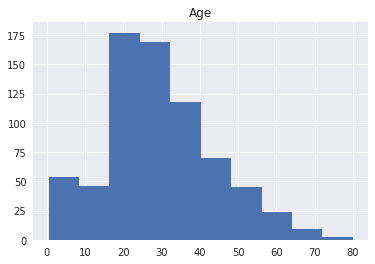

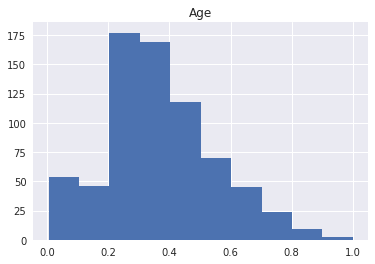

In [466]:
# Normalize continuous values
df.hist(column='Age');

df['Age'] = df['Age'] / df['Age'].max()
df.hist(column='Age');

(array([732, 106,  31,   2,  11,   6,   0,   0,   0,   3]), array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
       307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa93c1c9e8>]],
      dtype=object)

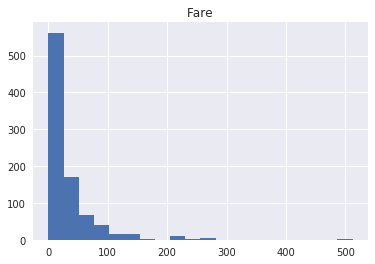

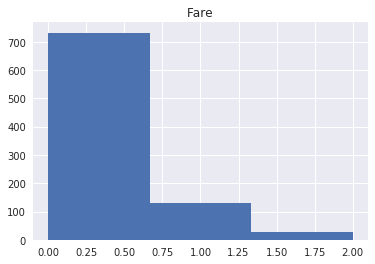

In [467]:
# Check for outliers
df.hist(column='Fare', bins=20);
print(np.histogram(df['Fare']))

# Let's create an ordinal variable here
df['Fare'] = np.where(
    df.Fare < 51, 0, np.where(
        df.Fare < 150, 1, 2)
)
df.hist(column='Fare', bins=3)

In [468]:
# Handle null
df.fillna({
    "Age": -1
}, inplace=True)

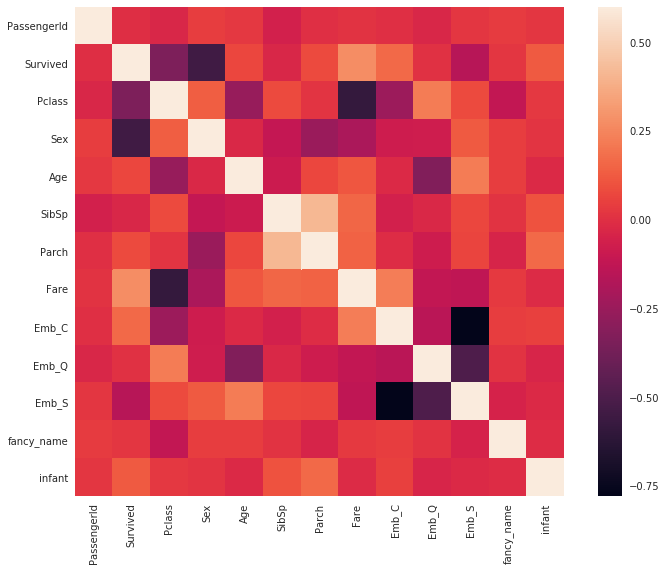

In [469]:
# Correlation
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.6, square=True);

In [470]:
# View the correlation coefficients
corrmat

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Emb_C,Emb_Q,Emb_S,fancy_name,infant
PassengerId,1.000000,-0.005007,-0.035144,0.042939,0.028784,-0.057527,-0.001652,0.010963,-0.001205,-0.033606,0.022148,0.039458,0.019509
Survived,-0.005007,1.000000,-0.338481,-0.543351,0.068515,-0.035322,0.081629,0.272582,0.168240,0.003650,-0.155660,0.022736,0.122966
Pclass,-0.035144,-0.338481,1.000000,0.131900,-0.260085,0.083081,0.018443,-0.588995,-0.243292,0.221009,0.081720,-0.120591,0.028934
Sex,0.042939,-0.543351,0.131900,1.000000,-0.028980,-0.114631,-0.245489,-0.194044,-0.082853,-0.074115,0.125722,0.045311,0.017640
Age,0.028784,0.068515,-0.260085,-0.028980,1.000000,-0.084383,0.067970,0.113215,-0.022779,-0.327402,0.220799,0.041108,-0.019476
SibSp,-0.057527,-0.035322,0.083081,-0.114631,-0.084383,1.000000,0.414838,0.155907,-0.059528,-0.026354,0.070941,0.008808,0.103813
Parch,-0.001652,0.081629,0.018443,-0.245489,0.067970,0.414838,1.000000,0.142611,-0.011069,-0.081228,0.063036,-0.045086,0.164202
Fare,0.010963,0.272582,-0.588995,-0.194044,0.113215,0.155907,0.142611,1.000000,0.223907,-0.118255,-0.129650,0.032439,-0.017891
Emb_C,-0.001205,0.168240,-0.243292,-0.082853,-0.022779,-0.059528,-0.011069,0.223907,1.000000,-0.148258,-0.778359,0.045371,0.054457
Emb_Q,-0.033606,0.003650,0.221009,-0.074115,-0.327402,-0.026354,-0.081228,-0.118255,-0.148258,1.000000,-0.496624,0.013069,-0.038860


In [471]:
# Get the n variables most correlated with Target (Survivied)
cols = corrmat.nsmallest(n=3, columns='Survived')['Survived'].index
cols

Index(['Sex', 'Pclass', 'Emb_S'], dtype='object')

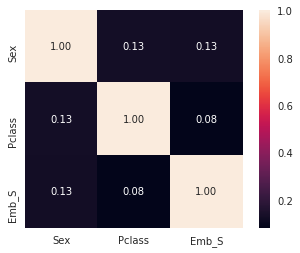

In [472]:
cm = np.corrcoef(df[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

In [473]:
cols = corrmat.nlargest(n=5, columns='Survived')['Survived'].index
cols

Index(['Survived', 'Fare', 'Emb_C', 'infant', 'Parch'], dtype='object')

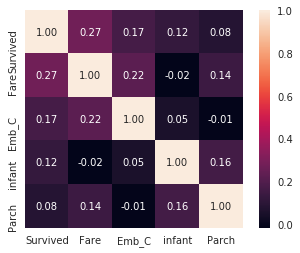

In [474]:
cm = np.corrcoef(df[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

In [475]:
X = df.copy()
Y = X['Survived'].values
X.drop(labels=['Survived','PassengerId'], axis=1, inplace=True)
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Emb_C,Emb_Q,Emb_S,fancy_name,infant
0,3,1,0.2750,1,0,0,0,0,1,0,0
1,1,0,0.4750,1,0,1,1,0,0,0,0
2,3,0,0.3250,0,0,0,0,0,1,0,0
3,1,0,0.4375,1,0,1,0,0,1,0,0
4,3,1,0.4375,0,0,0,0,0,1,0,0


In [476]:
from sklearn.model_selection import train_test_split

seed = 42

In [477]:
X_train, X_test, y_train, y_test = train_test_split(
    X.as_matrix(), Y, test_size=0.2, shuffle=True, random_state=seed, stratify=None)

In [478]:
X_train.shape, y_train.shape

((712, 11), (712,))

In [479]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

print("Train", model.score(X_train, y_train))
print("Test", model.score(X_test, y_test))

Train 0.8146067415730337
Test 0.7932960893854749


In [480]:
# Inspecting the coefficients in Logistic Regression is a bit tricky
# Not like Linear Regression! where the coefficients equal slop
# http://www.appstate.edu/~whiteheadjc/service/logit/intro.htm#interp
#https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/
    
print(X.columns.values)
model.coef_

['Pclass' 'Sex' 'Age' 'SibSp' 'Parch' 'Fare' 'Emb_C' 'Emb_Q' 'Emb_S'
 'fancy_name' 'infant']


array([[-0.63219929, -2.59726567,  0.14831006, -0.25607532, -0.12629988,
         0.41002813,  0.83971402,  0.62207069,  0.37161684,  0.13451688,
         2.2780036 ]])

In [481]:
#### Random Forest
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=10, min_samples_split=3)
model.fit(X_train, y_train)

print("Train", model.score(X_train, y_train))
print("Test", model.score(X_test, y_test))

Train 0.9129213483146067
Test 0.8044692737430168


In [482]:
print(X.columns.values)
model.feature_importances_

['Pclass' 'Sex' 'Age' 'SibSp' 'Parch' 'Fare' 'Emb_C' 'Emb_Q' 'Emb_S'
 'fancy_name' 'infant']


array([0.10300847, 0.30795096, 0.32358747, 0.08835681, 0.05807879,
       0.0547022 , 0.02065969, 0.00897334, 0.01731289, 0.00581696,
       0.01155243])

In [483]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(min_samples_split=12)
model.fit(X_train, y_train)

print("Train", model.score(X_train, y_train))
print("Test", model.score(X_test, y_test))

Train 0.8735955056179775
Test 0.8212290502793296


In [484]:
print(X.columns.values)
model.feature_importances_

['Pclass' 'Sex' 'Age' 'SibSp' 'Parch' 'Fare' 'Emb_C' 'Emb_Q' 'Emb_S'
 'fancy_name' 'infant']


array([0.17232018, 0.4668112 , 0.18561425, 0.03855295, 0.04064535,
       0.01157816, 0.005669  , 0.00219794, 0.03660317, 0.00396213,
       0.03604566])

In [485]:
# Plot the decision path!


### Submit scores to Kaggle

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


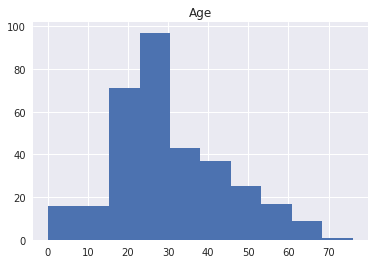

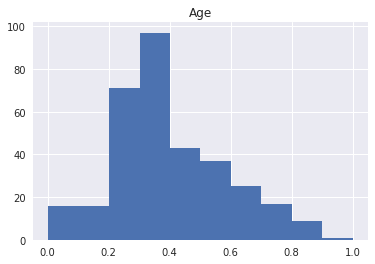

In [486]:
test = pd.read_csv(TEST_PATH)
test.info()
df = test.copy()

# Convert Categorical
df['Sex'] = df['Sex'].astype('category')
df['Sex'] = df['Sex'].cat.codes

# One-hot encode
df = pd.get_dummies(df, columns=['Embarked'], prefix=['Emb'])

# Create name feature
df['fancy_name'] = np.where(
    (df.Name.str.contains('Dr\.')) | (df.Name.str.contains('Sir\.'))
    , 1, 0)

# Create is_infant 
df['infant'] = np.where(np.logical_and(df.Age > 0, df.Age <= 1), 1, 0)

## Drop Silly rows
df.drop(labels=['Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

# Normalize continuous values
df.hist(column='Age');

df['Age'] = df['Age'] / df['Age'].max()
df.hist(column='Age');

# Let's create an ordinal variable here
df['Fare'] = np.where(
    df.Fare < 51, 0, np.where(
        df.Fare < 150, 1, 2)
)

# Handle null
df.fillna({
    "Age": -1
}, inplace=True)

In [487]:
df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Emb_C,Emb_Q,Emb_S,fancy_name,infant
0,892,3,1,0.453947,0,0,0,0,1,0,0,0
1,893,3,0,0.618421,1,0,0,0,0,1,0,0
2,894,2,1,0.815789,0,0,0,0,1,0,0,0
3,895,3,1,0.355263,0,0,0,0,0,1,0,0
4,896,3,0,0.289474,1,1,0,0,0,1,0,0


In [488]:
X = df.copy()
X.drop(labels=['PassengerId'], axis=1, inplace=True)
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Emb_C,Emb_Q,Emb_S,fancy_name,infant
0,3,1,0.453947,0,0,0,0,1,0,0,0
1,3,0,0.618421,1,0,0,0,0,1,0,0
2,2,1,0.815789,0,0,0,0,1,0,0,0
3,3,1,0.355263,0,0,0,0,0,1,0,0
4,3,0,0.289474,1,1,0,0,0,1,0,0


In [489]:
df.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Emb_C          0
Emb_Q          0
Emb_S          0
fancy_name     0
infant         0
dtype: int64

In [490]:
X_test = X.as_matrix()
X_test.shape

(418, 11)

In [491]:
# Decision Tree
preds = model.predict(X_test)

In [492]:
p_ids = df[['PassengerId']].values
p_ids = p_ids.flatten()


In [493]:
submission = pd.DataFrame(data={'PassengerId': p_ids, 'Survived':preds})
submission.to_csv('titanic_submission.csv', index=False)

In [494]:
test = pd.read_csv(TEST_PATH)
train = pd.read_csv(TRAIN_PATH)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [495]:
train.replace({
    "Sex": {
        "male": 0,
        "female": 1
    },
    "Embarked": {
        "S": 0,
        "C": 1,
        "Q": 2
    }
}, inplace=True)
test.replace({
    "Sex": {
        "male": 0,
        "female": 1
    },
    "Embarked": {
        "S": 0,
        "C": 1,
        "Q": 2
    }
}, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa938197f0>]],
      dtype=object)

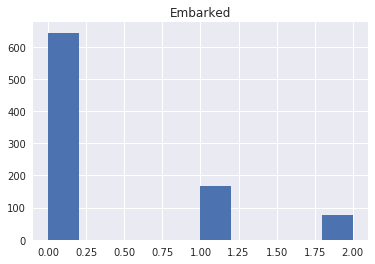

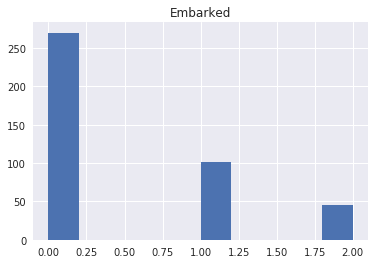

In [496]:
train.hist(column='Embarked')
test.hist(column='Embarked')

In [497]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### Resources

* http://fastml.com/converting-categorical-data-into-numbers-with-pandas-and-scikit-learn/